
Please set runtime to GPU accelerated



In [ ]:
pip install deepface==0.0.51

     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 2.3 MB 41.8 MB/s 
     |████████████████████████████████| 462 kB 69.7 MB/s 


In [ ]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=2937882b825f235d65b57bd3b36eb81f1b9c9d98ee68012a8150a77e66a79cbc
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [2]:
#Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory to where the my files are located
%cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok


In [ ]:
#import packages
from deepface import DeepFace
from deepface.basemodels import VGGFace
import os
from pathlib import Path
import gdown
import numpy as np

import face_recognition
import pandas as pd

from tqdm import tqdm
import pickle
import json


Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
#import fastAI
from fastai.vision import *
from fastai.metrics import error_rate


In [ ]:
#Load FastAI Models first
angle_model = load_learner('./models/FINAL_FastAI_HighLow/')
shot_model = load_learner('./models/3200ShotType_85pct')

In [ ]:
#Import Tensorflow for DeepFace
from keras.models import load_model
from keras.preprocessing import image
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

In [ ]:
#This code is taken from DeepFace's GitHub,a function to load the race model
def loadraceModel():
	
	model = VGGFace.baseModel()
	
	#--------------------------
	
	classes = 6
	base_model_output = Sequential()
	base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
	base_model_output = Flatten()(base_model_output)
	base_model_output = Activation('softmax')(base_model_output)
	
	#--------------------------

	race_model = Model(inputs=model.input, outputs=base_model_output)
	
	#--------------------------
	
	#load weights
	

	race_model.load_weights('./models/race_model_single_batch.h5')
	
	return race_model

In [ ]:
#This code is taken from DeepFace's GitHub,a function to load the gender model
def loadgenderModel():
	
	model = VGGFace.baseModel()
	
	#--------------------------
	
	classes = 2
	base_model_output = Sequential()
	base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
	base_model_output = Flatten()(base_model_output)
	base_model_output = Activation('softmax')(base_model_output)
	
	#--------------------------

	gender_model = Model(inputs=model.input, outputs=base_model_output)
	
	#--------------------------
	
	#load weights
	
	#home = str(Path.home())
	
	#if os.path.isfile(home+'/.deepface/weights/gender_model_weights.h5') != True:
	#	print("gender_model_weights.h5 will be downloaded...")
		
	#	url = 'https://drive.google.com/uc?id=1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk'
	#	output = home+'/.deepface/weights/gender_model_weights.h5'
	#	gdown.download(url, output, quiet=False)
	
	gender_model.load_weights('./models/gender_model_weights.h5')
	
	return gender_model

In [ ]:

def build_model(model_name):

	"""
	This function builds a deepface model
	Parameters:
		model_name (string): face recognition or facial attribute model
			VGG-Face, Facenet, OpenFace, DeepFace, DeepID for face recognition
			Age, Gender, Emotion, Race for facial attributes
	Returns:
		built deepface model
	"""

	models = {
		'VGG-Face': VGGFace.loadModel,

		#'Age': Age.loadModel,
		'Gender': loadgenderModel(),
		'Race': loadraceModel()
	}

	model = models.get(model_name)
 

In [ ]:
#This code is taken from DeepFace's GitHub,a function to run the models
from deepface.commons import functions, realtime, distance as dst
def analyze(img_path, actions = ['emotion', 'age', 'gender', 'race'] , models = {}, enforce_detection = True, detector_backend = 'mtcnn'):


	img_paths, bulkProcess = functions.initialize_input(img_path)
	functions.initialize_detector(detector_backend = detector_backend)

	#---------------------------------

	built_models = list(models.keys())

	#---------------------------------

	#pre-trained models passed but it doesn't exist in actions
	if len(built_models) > 0:
		if 'emotion' in built_models and 'emotion' not in actions:
			actions.append('emotion')

		if 'age' in built_models and 'age' not in actions:
			actions.append('age')

		if 'gender' in built_models and 'gender' not in actions:
			actions.append('gender')

		if 'race' in built_models and 'race' not in actions:
			actions.append('race')

	#---------------------------------

	if 'emotion' in actions and 'emotion' not in built_models:
		models['emotion'] = build_model('Emotion')

	if 'age' in actions and 'age' not in built_models:
		models['age'] = build_model('Age')

	if 'gender' in actions and 'gender' not in built_models:
		models['gender'] = build_model('Gender')

	if 'race' in actions and 'race' not in built_models:
		models['race'] = build_model('Race')

	#---------------------------------

	resp_objects = []

	disable_option = False if len(img_paths) > 1 else True

	global_pbar = tqdm(range(0,len(img_paths)), desc='Analyzing', disable = disable_option)

	for j in global_pbar:
		img_path = img_paths[j]

		resp_obj = {}

		disable_option = False if len(actions) > 1 else True

		pbar = tqdm(range(0,len(actions)), desc='Finding actions', disable = disable_option)

		img_224 = None # Set to prevent re-detection

		region = [] # x, y, w, h of the detected face region
		region_labels = ['x', 'y', 'w', 'h']

		#facial attribute analysis
		for index in pbar:
			action = actions[index]
			pbar.set_description("Action: %s" % (action))

			if action == 'emotion':
				emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
				img, region = functions.preprocess_face(img = img_path, target_size = (48, 48), grayscale = True, enforce_detection = enforce_detection, detector_backend = detector_backend, return_region = True)

				resp_obj["region"] = {}

				for i, parameter in enumerate(region_labels):
					resp_obj["region"][parameter] = region[i]

				emotion_predictions = models['emotion'].predict(img)[0,:]

				sum_of_predictions = emotion_predictions.sum()

				resp_obj["emotion"] = {}

				for i in range(0, len(emotion_labels)):
					emotion_label = emotion_labels[i]
					emotion_prediction = 100 * emotion_predictions[i] / sum_of_predictions
					resp_obj["emotion"][emotion_label] = emotion_prediction

				resp_obj["dominant_emotion"] = emotion_labels[np.argmax(emotion_predictions)]

			elif action == 'age':
				if img_224 is None:
					img_224, region = functions.preprocess_face(img = img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection, detector_backend = detector_backend, return_region = True)

				resp_obj["region"] = {}

				for i, parameter in enumerate(region_labels):
					resp_obj["region"][parameter] = region[i]

				age_predictions = models['age'].predict(img_224)[0,:]
				apparent_age = Age.findApparentAge(age_predictions)

				resp_obj["age"] = int(apparent_age)

			elif action == 'gender':
				if img_224 is None:
					img_224, region = functions.preprocess_face(img = img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection, detector_backend = detector_backend, return_region = True)

				resp_obj["region"] = {}

				for i, parameter in enumerate(region_labels):
					resp_obj["region"][parameter] = region[i]

				gender_prediction = models['gender'].predict(img_224)[0,:]

				if np.argmax(gender_prediction) == 0:
					gender = "Woman"
				elif np.argmax(gender_prediction) == 1:
					gender = "Man"

				resp_obj["gender"] = gender

			elif action == 'race':
				if img_224 is None:
					img_224, region = functions.preprocess_face(img = img_path, target_size = (224, 224), grayscale = False, enforce_detection = enforce_detection, detector_backend = detector_backend, return_region = True) #just emotion model expects grayscale images
				race_predictions = models['race'].predict(img_224)[0,:]
				race_labels = ['asian', 'indian', 'black', 'white', 'middle eastern', 'latino hispanic']

				resp_obj["region"] = {}

				for i, parameter in enumerate(region_labels):
					resp_obj["region"][parameter] = region[i]

				sum_of_predictions = race_predictions.sum()

				resp_obj["race"] = {}
				for i in range(0, len(race_labels)):
					race_label = race_labels[i]
					race_prediction = 100 * race_predictions[i] / sum_of_predictions
					resp_obj["race"][race_label] = race_prediction

				resp_obj["dominant_race"] = race_labels[np.argmax(race_predictions)]

		#---------------------------------

		if bulkProcess == True:
			resp_objects.append(resp_obj)
		else:
			return resp_obj

	if bulkProcess == True:

		resp_obj = {}

		for i in range(0, len(resp_objects)):
			resp_item = resp_objects[i]
			resp_obj["instance_%d" % (i+1)] = resp_item

		return resp_obj

In [ ]:
#Declare variables for the models
models = {}
models["gender"]=loadgenderModel()
models["race"] = loadraceModel()

In [ ]:
# The functions inside the predict class are the prediction functions written by me, for my thesis
class Predict():
# check_face retuns 0 if there is no face, or the number of faces on an image
    def check_face(file):
      #load image
        img = cv2.imread(file,1)
        #image = np.array(img)
        image = face_recognition.load_image_file(file)
# run the face recognition on an image
        face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=1, model="cnn")

        if len(face_locations) > 0:
#If there is a face detected create a list of point using face landmarks. 
#These will be used when calculating the contrast ratio of the face.
# points and points2 are the point of interest on the face. ROI and ROI2 are the rectangle we draw from these points.
            lista = face_recognition.face_landmarks(img,face_locations = face_locations)
            points = [lista[0]['chin'][0],lista[0]['nose_bridge'][-1]]
            points2 = [lista[0]['nose_bridge'][0],lista[0]['chin'][-4]]
            ROI = img[points[0][1]:points[1][1], points[0][0]:points[1][0]]
            ROI2 = img[points2[0][1]:points2[1][1], points2[0][0]:points2[1][0]]
            return len(face_locations),ROI,ROI2
        else:
            return 0,0,0

# analyze function runs the FastAI prediction on a selected image

    def analyze(image,model1,model2):
        new_img = open_image(image)
        pred1 = str(model1.predict(new_img)[0])
        pred2 = str(model2.predict(new_img)[0])
        #class1 = category1[int(pred1)]
        #class2 = category2[int(pred2)]
        return pred1,pred2
        


In [ ]:
# This function takes the ROI rectangles above and calculates the brightness value of each pixel,
# Then gives us the average brightness of that territory. If we do this for both side of the face we get the contrast ratio


from numpy.linalg import norm
#https://stackoverflow.com/questions/14243472/estimate-brightness-of-an-image-opencv

def brightness(img):

    if type(img) == int:
        return str(0)
    elif len(img.shape) == 3:
        # Colored RGB or BGR (*Do Not* use HSV images with this function)
        # create brightness with euclidean norm
        return str(np.average(norm(img, axis=2)) / np.sqrt(3))
    else:
        # Grayscale
        return str(np.average(img))





# Fistful Of Dollars

In [ ]:
# change direcrory to where the images are
%cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDollars

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDollars


In [ ]:
import glob
#create a list from all the jpg files
lista = glob.glob('./*.jpg')
# take every third file, since SceneDetect saves three images for every shot
lst = lista[0::3]

In [ ]:
from PIL import Image

In [ ]:
#resize the selected images for easier processing. Only do this if you run scenedetect on a video.
# Skip this step on the attached files
for i in lista:
  #read the image
  img = cv2.imread(i,1)
  # take the width and heigth of the images
  original_width = img.shape[1]
  original_height = img.shape[0]
  # Take half width heigth of the image
  width = original_width // 2
  height = original_height // 2
  # Resize the image to half of the original
  size = (width,height)
  im = cv2.resize(img,size)
  # Create the new image
  cv2.imwrite(i,im)
 


In [ ]:
#Create lists for all the data we're about to extract
filename_list = []
face_list = []
race_list = []
gender_list = []
brightness_list = []
angle_return = []
shot_return = []
#shot_class = ['CU','MC','ML','Long']
#angle_class = ['High','Med','Low']

In [ ]:
len(lista)

3123

In [ ]:
len(lst)

1041

In [ ]:
for file in lst:
    #print(file)
    # check the faces on the images
    face,ROI,ROI2 = Predict.check_face(file)
    face_list.append(face)

    # Run the FastAI models, append the lists with the data
    shot_type,angle_result = Predict.analyze(file,shot_model,angle_model)
    shot_return.append(shot_type)
    angle_return.append(angle_result)
    # If the image is a close up, run DeepFace models. This saves processing time.
    # append the race  and gender data. 
    if 'CU' in shot_type:
      race_class = analyze(file,actions=['race'],models=models, enforce_detection=False)
      race_data = race_class.get("dominant_race")
      race_list.append(race_data)
      #print(file,shot_type)
      gender = analyze(file,actions=['gender'],models=models, enforce_detection=False)
      gender_data = gender.get("gender")
      gender_list.append(gender_data)
    else:
      gender_list.append(0)
      race_list.append(0)

# append the filenames to a list.
    filename_list.append(file) 

# Note: Processing an entire feature film could take up to an hour.
    


Action: race: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


# Fistful of Dollars Data

In [ ]:
#Create a pandas dataframe from the lists.
df = pd.DataFrame(list(zip(filename_list,face_list,angle_return,shot_return,gender_list,race_list)), columns = ['Filename','Face','CameraAngle','ShotType','Gender','Race'])
df

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,1,Med,CU,Man,middle eastern
1,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,High,CU,Man,white
2,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Man,asian
3,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,1,Med,CU,Man,latino hispanic
4,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,1,Med,CU,Man,middle eastern
...,...,...,...,...,...,...
1036,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,MC,0,0
1037,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Woman,white
1038,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Man,middle eastern
1039,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,ML,0,0


In [ ]:
# Save the data to a csv file
df.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDollars_AllImg.csv',index=False)

In [ ]:
# Filter out the Close Ups
df_CU = df.loc[df['ShotType'] == 'CU']
df_CU

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,1,Med,CU,Man,middle eastern
1,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,High,CU,Man,white
2,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Man,asian
3,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,1,Med,CU,Man,latino hispanic
4,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,1,Med,CU,Man,middle eastern
...,...,...,...,...,...,...
1025,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Man,middle eastern
1028,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Man,white
1029,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,High,CU,Woman,white
1037,./A.Fistful.of.Dollars.1964.BDRip.x264.HUN-CRW...,0,Med,CU,Woman,white


In [ ]:
# Save the filtered Close Up dataframe to a csv file
df_CU.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDollars_Close_Ups.csv',index=False)

In [ ]:
Dollars_CU = list(df_CU.Filename)
len(Dollars_CU)

368

In [4]:
# Create a dataframe for the images classified as white, count them.
df_white = df_CU.loc[df_CU['Race'] == 'white']
white = len(df_white.Race)
white

179

In [5]:
# Create a dataframe for the images classified as non-white, count them.
df_non_white = df_CU.loc[df_CU['Race'] != 'white']
non_white = len(df_non_white.Race)
non_white

189

In [6]:
# Count the camera angles based on ethnicity
non_white_High = df_non_white.CameraAngle.value_counts().High
non_white_Med = df_non_white.CameraAngle.value_counts().Med
non_white_Low = df_non_white.CameraAngle.value_counts().Low

In [7]:
# Count the camera angles based on ethnicity
white_High = df_white.CameraAngle.value_counts().High
white_Med = df_white.CameraAngle.value_counts().Med
white_Low = df_white.CameraAngle.value_counts().Low

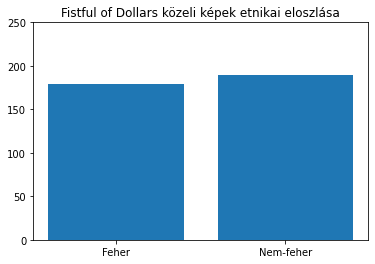

In [ ]:
import matplotlib.pyplot as plt
#Create a barchart based on the ethnicity data.   
values = [white, non_white]
plt.bar(['Feher','Nem-feher' ],values)
plt.ylim(0,250)
plt.title('Fistful of Dollars közeli képek etnikai eloszlása')
plt.show()

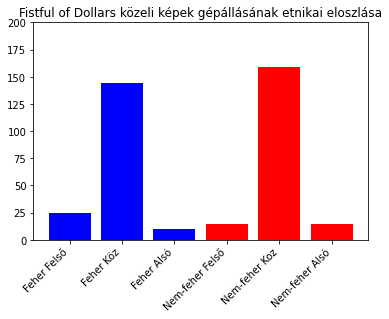

In [8]:
import matplotlib.pyplot as plt
# Create a barchart based on the Shot Angle data and Ethnicity Data   
values = [white_High,white_Med, white_Low,non_white_High,non_white_Med,non_white_Low]
plt.bar(['Feher Felső', 'Feher Köz', 'Feher Alsó','Nem-feher Felső','Nem-feher Koz','Nem-feher Alsó' ],values, color = ['blue','blue','blue','red','red','red'])
plt.ylim(0,200)
plt.xticks(rotation=45, ha='right')
plt.title('Fistful of Dollars közeli képek gépállásának etnikai eloszlása')
plt.show()




In [ ]:
white

179

In [ ]:
Dollars_CU = list(df_CU.Filename)
len(Dollars_CU)
# Copy all the Close ups to a different folder.
import shutil
for i in Dollars_CU:
  shutil.copy(i,'/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDollars_CloseUps' )

In [ ]:
# The steps shows above can be repeated for all the other films. 

# Fistful Of Dynamite

In [ ]:
% cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite


In [ ]:
import glob
lista = glob.glob('./*.jpg')
lst = lista[0::3]

In [ ]:
len(lst)

1497

In [ ]:
for i in lista:
  img = cv2.imread(i,1)
  original_width = img.shape[1]
  original_height = img.shape[0]
  width = original_width // 3
  height = original_height // 3
  size = (width,height)
  im = cv2.resize(img,size)
  cv2.imwrite(i,im)
 


In [ ]:
din_filename_list = []
din_face_list = []
din_race_list = []
din_gender_list = []
din_brightness_list = []
din_angle_return = []
din_shot_return = []

In [ ]:
for file in lst:
    #print(file)
    face,ROI,ROI2 = Predict.check_face(file)
    din_face_list.append(face)

    shot_type,angle_result = Predict.analyze(file,shot_model,angle_model)
    din_shot_return.append(shot_type)
    din_angle_return.append(angle_result)
    if 'CU' in shot_type:
      race_class = analyze(file,actions=['race'],models=models, enforce_detection=False)
      race_data = race_class.get("dominant_race")
      din_race_list.append(race_data)
      #print(file,shot_type)
      gender = analyze(file,actions=['gender'],models=models, enforce_detection=False)
      gender_data = gender.get("gender")
      din_gender_list.append(gender_data)
    else:
      din_gender_list.append(0)
      din_race_list.append(0)


    din_filename_list.append(file) 


    


Action: race: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


In [ ]:
df_dynamite = pd.DataFrame(list(zip(din_filename_list,din_face_list,din_angle_return,din_shot_return,din_gender_list,din_race_list)), columns = ['Filename','Face','CameraAngle','ShotType','Gender','Race'])
df_dynamite

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Low,ML,0,0
1,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,High,ML,0,0
2,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,MC,0,0
3,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Low,CU,Man,indian
4,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,ML,0,0
...,...,...,...,...,...,...
1492,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,L,0,0
1493,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,black
1494,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,High,L,0,0
1495,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,L,0,0


In [ ]:
df_dynamite.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite_AllImg.csv',index=False)

#Fistful of Dynamite Data

In [ ]:
import pandas as pd

df_dynamite = pd.read_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite_AllImg.csv')
df_dynamite

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Low,ML,0,0
1,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,High,ML,0,0
2,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,MC,0,0
3,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Low,CU,Man,indian
4,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,ML,0,0
...,...,...,...,...,...,...
1492,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,L,0,0
1493,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,black
1494,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,High,L,0,0
1495,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,L,0,0


In [ ]:
df_din_CU = df_dynamite.loc[df_dynamite['ShotType'] == 'CU']
df_din_CU

,Filename,Face,CameraAngle,ShotType,Gender,Race
3,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Low,CU,Man,indian
8,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,white
10,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Med,CU,Man,black
12,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Med,CU,Man,latino hispanic
14,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Med,CU,Man,black
...,...,...,...,...,...,...
1478,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,latino hispanic
1480,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,High,CU,Man,middle eastern
1481,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,High,CU,Man,black
1487,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,white


In [ ]:
df_din_CU.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite_Close_Ups.csv',index=False)

In [ ]:
df_din_white = df_din_CU.loc[df_din_CU['Race'] == 'white']
white = len(df_din_white.Race)
white

287

In [ ]:
df_din_non_white = df_din_CU.loc[df_din_CU['Race'] != 'white']
non_white = len(df_din_non_white.Race)
non_white

387

In [ ]:
din_white_High = df_din_white.CameraAngle.value_counts().High
din_white_Med = df_din_white.CameraAngle.value_counts().Med
din_white_Low = df_din_white.CameraAngle.value_counts().Low

In [ ]:
din_non_white_High = df_din_non_white.CameraAngle.value_counts().High
din_non_white_Med = df_din_non_white.CameraAngle.value_counts().Med
din_non_white_Low = df_din_non_white.CameraAngle.value_counts().Low

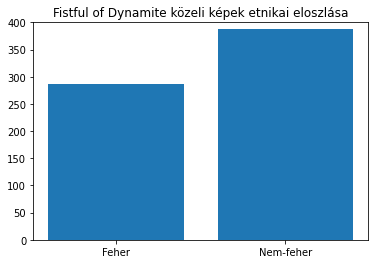

In [ ]:
import matplotlib.pyplot as plt
   
values = [white, non_white]
plt.bar(['Feher','Nem-feher' ],values)
plt.ylim(0,400)
plt.title('Fistful of Dynamite közeli képek etnikai eloszlása')
plt.show()

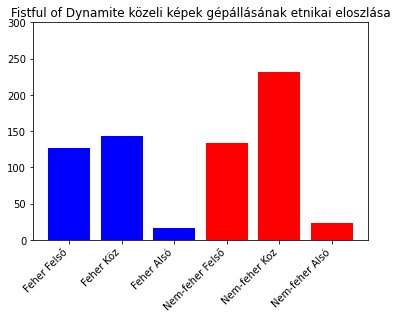

In [ ]:
import matplotlib.pyplot as plt
   
values = [din_white_High,din_white_Med, din_white_Low,din_non_white_High,din_non_white_Med,din_non_white_Low]

plt.bar(['Feher Felső', 'Feher Köz', 'Feher Alsó','Nem-feher Felső','Nem-feher Koz','Nem-feher Alsó' ],values, color = ['blue','blue','blue','red','red','red'])
plt.ylim(0,300)
plt.xticks(rotation=45, ha='right')
plt.title('Fistful of Dynamite közeli képek gépállásának etnikai eloszlása')
plt.show()




In [ ]:
% cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite

Dynamite_CU = list(df_din_CU.Filename)
len(Dynamite_CU)

import shutil
for i in Dynamite_CU:
  shutil.copy(i,'/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite_CloseUps' )

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FistfulOfDynamite


# Once Upon a Time In The West

In [ ]:
% cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/OnceUponInTheWest

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/OnceUponInTheWest


In [ ]:
import glob
lista = glob.glob('./*.jpg')
lst = lista[0::3]

In [ ]:
len(lst)

1549

In [ ]:
for i in lista:
  img = cv2.imread(i,1)
  original_width = img.shape[1]
  original_height = img.shape[0]
  width = original_width // 3
  height = original_height // 3
  size = (width,height)
  im = cv2.resize(img,size)
  cv2.imwrite(i,im)
 


In [ ]:
west_filename_list = []
west_face_list = []
west_race_list = []
west_gender_list = []
west_brightness_list = []
west_angle_return = []
west_shot_return = []

In [ ]:
for file in lst:
    #print(file)
    face,ROI,ROI2 = Predict.check_face(file)
    west_face_list.append(face)

    shot_type,angle_result = Predict.analyze(file,shot_model,angle_model)
    west_shot_return.append(shot_type)
    west_angle_return.append(angle_result)
    if 'CU' in shot_type:
      race_class = analyze(file,actions=['race'],models=models, enforce_detection=False)
      race_data = race_class.get("dominant_race")
      west_race_list.append(race_data)
      #print(file,shot_type)
      gender = analyze(file,actions=['gender'],models=models, enforce_detection=False)
      gender_data = gender.get("gender")
      west_gender_list.append(gender_data)
    else:
      west_gender_list.append(0)
      west_race_list.append(0)


    west_filename_list.append(file) 


    


Action: race: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


In [ ]:
df_west = pd.DataFrame(list(zip(west_filename_list,west_face_list,west_angle_return,west_shot_return,west_gender_list,west_race_list)), columns = ['Filename','Face','CameraAngle','ShotType','Gender','Race'])
df_west

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./Cera.Una.Volta.Il.West.1968.-Scene-1216-03.jpg,0,Med,ML,0,0
1,./Cera.Una.Volta.Il.West.1968.-Scene-1217-03.jpg,0,Med,L,0,0
2,./Cera.Una.Volta.Il.West.1968.-Scene-1218-03.jpg,1,Med,CU,Man,white
3,./Cera.Una.Volta.Il.West.1968.-Scene-1219-03.jpg,0,Med,L,0,0
4,./Cera.Una.Volta.Il.West.1968.-Scene-1220-03.jpg,1,Low,CU,Man,white
...,...,...,...,...,...,...
1544,./Cera.Una.Volta.Il.West.1968.-Scene-0211-03.jpg,0,High,L,0,0
1545,./Cera.Una.Volta.Il.West.1968.-Scene-0212-03.jpg,0,Med,MC,0,0
1546,./Cera.Una.Volta.Il.West.1968.-Scene-0213-03.jpg,0,Med,L,0,0
1547,./Cera.Una.Volta.Il.West.1968.-Scene-0214-03.jpg,0,Med,MC,0,0


In [ ]:
df_west.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/OnceUponATime_AllImg.csv',index=False)

# Once upon a Time Data

In [ ]:
df_west = pd.read_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/OnceUponATime_AllImg.csv')
df_west

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./Cera.Una.Volta.Il.West.1968.-Scene-1216-03.jpg,0,Med,ML,0,0
1,./Cera.Una.Volta.Il.West.1968.-Scene-1217-03.jpg,0,Med,L,0,0
2,./Cera.Una.Volta.Il.West.1968.-Scene-1218-03.jpg,1,Med,CU,Man,white
3,./Cera.Una.Volta.Il.West.1968.-Scene-1219-03.jpg,0,Med,L,0,0
4,./Cera.Una.Volta.Il.West.1968.-Scene-1220-03.jpg,1,Low,CU,Man,white
...,...,...,...,...,...,...
1544,./Cera.Una.Volta.Il.West.1968.-Scene-0211-03.jpg,0,High,L,0,0
1545,./Cera.Una.Volta.Il.West.1968.-Scene-0212-03.jpg,0,Med,MC,0,0
1546,./Cera.Una.Volta.Il.West.1968.-Scene-0213-03.jpg,0,Med,L,0,0
1547,./Cera.Una.Volta.Il.West.1968.-Scene-0214-03.jpg,0,Med,MC,0,0


In [ ]:
df_west_CU = df_dynamite.loc[df_west['ShotType'] == 'CU']
df_west_CU

,Filename,Face,CameraAngle,ShotType,Gender,Race
2,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,MC,0,0
4,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,ML,0,0
6,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Med,MC,0,0
8,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,white
10,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,1,Med,CU,Man,black
...,...,...,...,...,...,...
1476,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,ML,0,0
1487,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,CU,Man,white
1490,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,L,0,0
1495,./A.Fistful.of.Dynamite.1971.BDRip.x264.HUN-CR...,0,Med,L,0,0


In [ ]:
df_west_CU.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/OnceUponATime_Close_Ups.csv',index=False)

In [ ]:
df_west_white = df_west_CU.loc[df_west_CU['Race'] == 'white']
white = len(df_west_white.Race)
white

135

In [ ]:
df_west_non_white = df_west_CU.loc[df_west_CU['Race'] != 'white']
non_white = len(df_west_non_white.Race)
non_white

525

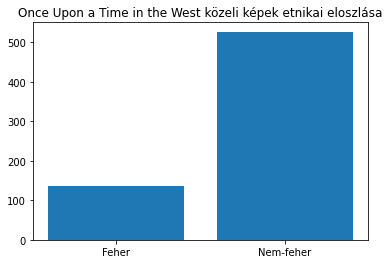

In [ ]:
import matplotlib.pyplot as plt
   
values = [white, non_white]
plt.bar(['Feher','Nem-feher' ],values)
plt.ylim(0,550)
plt.title('Once Upon a Time in the West közeli képek etnikai eloszlása')
plt.show()

In [ ]:
west_white_High = df_west_white.CameraAngle.value_counts().High
west_white_Med = df_west_white.CameraAngle.value_counts().Med
west_white_Low = df_west_white.CameraAngle.value_counts().Low

In [ ]:
west_non_white_High = df_west_non_white.CameraAngle.value_counts().High
west_non_white_Med = df_west_non_white.CameraAngle.value_counts().Med
west_non_white_Low = df_west_non_white.CameraAngle.value_counts().Low

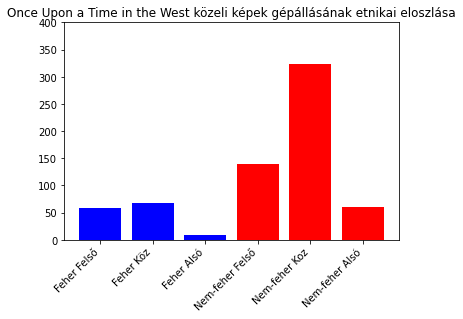

In [ ]:
import matplotlib.pyplot as plt
   
values = [west_white_High,west_white_Med, west_white_Low,west_non_white_High,west_non_white_Med,west_non_white_Low]

plt.bar(['Feher Felső', 'Feher Köz', 'Feher Alsó','Nem-feher Felső','Nem-feher Koz','Nem-feher Alsó' ],values, color = ['blue','blue','blue','red','red','red'])
plt.ylim(0,400)
plt.xticks(rotation=45, ha='right')
plt.title('Once Upon a Time in the West közeli képek gépállásának etnikai eloszlása')
plt.show()




# Few Dollars More

In [ ]:
% cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FewDollarsMore

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FewDollarsMore


In [ ]:
import glob
lista = glob.glob('./*.jpg')
lst = lista[0::3]

In [ ]:
len(lst)

1714

In [ ]:
for i in lista:
  img = cv2.imread(i,1)
  original_width = img.shape[1]
  original_height = img.shape[0]
  width = original_width // 3
  height = original_height // 3
  size = (width,height)
  im = cv2.resize(img,size)
  cv2.imwrite(i,im)
 


In [ ]:
more_filename_list = []
more_face_list = []
more_race_list = []
more_gender_list = []
more_brightness_list = []
more_angle_return = []
more_shot_return = []

In [ ]:
for file in lst:
    #print(file)
    face,ROI,ROI2 = Predict.check_face(file)
    more_face_list.append(face)

    shot_type,angle_result = Predict.analyze(file,shot_model,angle_model)
    more_shot_return.append(shot_type)
    more_angle_return.append(angle_result)
    if 'CU' in shot_type:
      race_class = analyze(file,actions=['race'],models=models, enforce_detection=False)
      race_data = race_class.get("dominant_race")
      more_race_list.append(race_data)
      #print(file,shot_type)
      gender = analyze(file,actions=['gender'],models=models, enforce_detection=False)
      gender_data = gender.get("gender")
      more_gender_list.append(gender_data)
    else:
      more_gender_list.append(0)
      more_race_list.append(0)


    more_filename_list.append(file) 


    


Action: race: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


In [ ]:
df_more = pd.DataFrame(list(zip(more_filename_list,more_face_list,more_angle_return,more_shot_return,more_gender_list,more_race_list)), columns = ['Filename','Face','CameraAngle','ShotType','Gender','Race'])
df_more

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./for.a.few.dollars.more-Scene-1381-03.jpg,0,Med,MC,0,0
1,./for.a.few.dollars.more-Scene-1382-03.jpg,0,Med,MC,0,0
2,./for.a.few.dollars.more-Scene-1383-03.jpg,1,High,MC,0,0
3,./for.a.few.dollars.more-Scene-1384-03.jpg,1,Med,MC,0,0
4,./for.a.few.dollars.more-Scene-1385-03.jpg,0,Med,L,0,0
...,...,...,...,...,...,...
1709,./for.a.few.dollars.more-Scene-0043-02.jpg,0,Med,L,0,0
1710,./for.a.few.dollars.more-Scene-0044-02.jpg,0,Med,MC,0,0
1711,./for.a.few.dollars.more-Scene-0045-02.jpg,0,Med,MC,0,0
1712,./for.a.few.dollars.more-Scene-0046-02.jpg,1,Med,CU,Man,white


In [ ]:
df_more.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/FewDollarsMore_AllImg.csv',index=False)

# FewDollarsMore Data

In [ ]:
df_more_CU = df_more.loc[df_more['ShotType'] == 'CU']
df_more_CU

,Filename,Face,CameraAngle,ShotType,Gender,Race
5,./for.a.few.dollars.more-Scene-1386-03.jpg,1,Med,CU,Man,middle eastern
6,./for.a.few.dollars.more-Scene-1387-03.jpg,1,Med,CU,Man,black
14,./for.a.few.dollars.more-Scene-1395-03.jpg,1,High,CU,Man,black
23,./for.a.few.dollars.more-Scene-1404-03.jpg,1,Med,CU,Man,indian
25,./for.a.few.dollars.more-Scene-1406-03.jpg,1,Med,CU,Man,middle eastern
...,...,...,...,...,...,...
1688,./for.a.few.dollars.more-Scene-0022-02.jpg,1,Med,CU,Man,white
1689,./for.a.few.dollars.more-Scene-0023-02.jpg,1,Med,CU,Man,middle eastern
1690,./for.a.few.dollars.more-Scene-0024-02.jpg,0,Med,CU,Man,white
1700,./for.a.few.dollars.more-Scene-0034-02.jpg,0,High,CU,Man,white


In [ ]:
df_more_white = df_more_CU.loc[df_more_CU['Race'] == 'white']
white = len(df_more_white.Race)
white

264

In [ ]:
df_more_non_white = df_more_CU.loc[df_more_CU['Race'] != 'white']
non_white = len(df_more_non_white.Race)
non_white

414

In [ ]:
more_white_High = df_more_white.CameraAngle.value_counts().High
more_white_Med = df_more_white.CameraAngle.value_counts().Med
more_white_Low = df_more_white.CameraAngle.value_counts().Low

In [ ]:
more_non_white_High = df_more_non_white.CameraAngle.value_counts().High
more_non_white_Med = df_more_non_white.CameraAngle.value_counts().Med
more_non_white_Low = df_more_non_white.CameraAngle.value_counts().Low

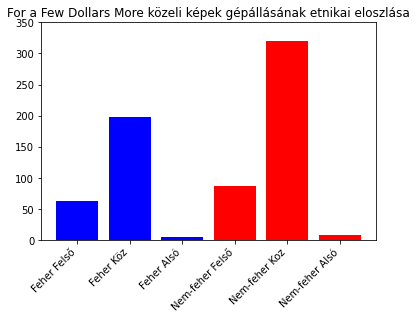

In [ ]:
import matplotlib.pyplot as plt
   
values = [more_white_High,more_white_Med, more_white_Low,more_non_white_High,more_non_white_Med,more_non_white_Low]

plt.bar(['Feher Felső', 'Feher Köz', 'Feher Alsó','Nem-feher Felső','Nem-feher Koz','Nem-feher Alsó' ],values, color = ['blue','blue','blue','red','red','red'])
plt.ylim(0,350)
plt.xticks(rotation=45, ha='right')
plt.title('For a Few Dollars More közeli képek gépállásának etnikai eloszlása')
plt.show()




# The Good the Bad and the Ugly

In [ ]:
% cd /content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/GoodBadUgly

/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/GoodBadUgly


In [ ]:
import glob
lista = glob.glob('./*.jpg')
lst = lista[0::3]

In [ ]:
len(lst)

1459

In [ ]:
for i in lista:
  img = cv2.imread(i,1)
  original_width = img.shape[1]
  original_height = img.shape[0]
  width = original_width // 3
  height = original_height // 3
  size = (width,height)
  im = cv2.resize(img,size)
  cv2.imwrite(i,im)
 


In [ ]:
GBU_filename_list = []
GBU_face_list = []
GBU_race_list = []
GBU_gender_list = []
GBU_brightness_list = []
GBU_angle_return = []
GBU_shot_return = []

In [ ]:
for file in lst:
    #print(file)
    face,ROI,ROI2 = Predict.check_face(file)
    GBU_face_list.append(face)

    shot_type,angle_result = Predict.analyze(file,shot_model,angle_model)
    GBU_shot_return.append(shot_type)
    GBU_angle_return.append(angle_result)
    if 'CU' in shot_type:
      race_class = analyze(file,actions=['race'],models=models, enforce_detection=False)
      race_data = race_class.get("dominant_race")
      GBU_race_list.append(race_data)
      #print(file,shot_type)
      gender = analyze(file,actions=['gender'],models=models, enforce_detection=False)
      gender_data = gender.get("gender")
      GBU_gender_list.append(gender_data)
    else:
      GBU_gender_list.append(0)
      GBU_race_list.append(0)


    GBU_filename_list.append(file) 


    


Action: race: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


In [ ]:
df_GBU = pd.DataFrame(list(zip(GBU_filename_list,GBU_face_list,GBU_angle_return,GBU_shot_return,GBU_gender_list,GBU_race_list)), columns = ['Filename','Face','CameraAngle','ShotType','Gender','Race'])
df_GBU

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./The.Good.The.Bad.The.Ugly.1966-Scene-1126-03...,0,High,CU,Man,middle eastern
1,./The.Good.The.Bad.The.Ugly.1966-Scene-1127-03...,1,High,CU,Man,white
2,./The.Good.The.Bad.The.Ugly.1966-Scene-1128-03...,0,Med,L,0,0
3,./The.Good.The.Bad.The.Ugly.1966-Scene-1129-03...,0,Low,L,0,0
4,./The.Good.The.Bad.The.Ugly.1966-Scene-1130-03...,0,Med,L,0,0
...,...,...,...,...,...,...
1454,./The.Good.The.Bad.The.Ugly.1966-Scene-0121-03...,1,Med,CU,Man,indian
1455,./The.Good.The.Bad.The.Ugly.1966-Scene-0122-03...,1,Med,CU,Man,indian
1456,./The.Good.The.Bad.The.Ugly.1966-Scene-0123-03...,1,Med,CU,Man,indian
1457,./The.Good.The.Bad.The.Ugly.1966-Scene-0124-03...,1,Med,CU,Man,indian


In [ ]:
df_GBU.to_csv('/content/drive/MyDrive/Marton Mátyás szakdolgozat programok/filmek/GoodBadandUgly_AllImg.csv',index=False)

In [ ]:
df_GBU_CU = df_GBU.loc[df_GBU['ShotType'] == 'CU']
df_GBU_CU

,Filename,Face,CameraAngle,ShotType,Gender,Race
0,./The.Good.The.Bad.The.Ugly.1966-Scene-1126-03...,0,High,CU,Man,middle eastern
1,./The.Good.The.Bad.The.Ugly.1966-Scene-1127-03...,1,High,CU,Man,white
13,./The.Good.The.Bad.The.Ugly.1966-Scene-1139-03...,0,Med,CU,Man,white
15,./The.Good.The.Bad.The.Ugly.1966-Scene-1141-03...,0,High,CU,Man,asian
18,./The.Good.The.Bad.The.Ugly.1966-Scene-1144-03...,0,Low,CU,Man,white
...,...,...,...,...,...,...
1454,./The.Good.The.Bad.The.Ugly.1966-Scene-0121-03...,1,Med,CU,Man,indian
1455,./The.Good.The.Bad.The.Ugly.1966-Scene-0122-03...,1,Med,CU,Man,indian
1456,./The.Good.The.Bad.The.Ugly.1966-Scene-0123-03...,1,Med,CU,Man,indian
1457,./The.Good.The.Bad.The.Ugly.1966-Scene-0124-03...,1,Med,CU,Man,indian


In [ ]:
df_GBU_white = df_GBU_CU.loc[df_GBU_CU['Race'] == 'white']
white = len(df_GBU_white.Race)
white

247

In [ ]:
df_GBU_non_white = df_GBU_CU.loc[df_GBU_CU['Race'] != 'white']
non_white = len(df_GBU_non_white.Race)
non_white

399

In [ ]:
GBU_white_High = df_GBU_white.CameraAngle.value_counts().High
GBU_white_Med = df_GBU_white.CameraAngle.value_counts().Med
GBU_white_Low = df_GBU_white.CameraAngle.value_counts().Low

In [ ]:
GBU_non_white_High = df_GBU_non_white.CameraAngle.value_counts().High
GBU_non_white_Med = df_GBU_non_white.CameraAngle.value_counts().Med
GBU_non_white_Low = df_GBU_non_white.CameraAngle.value_counts().Low

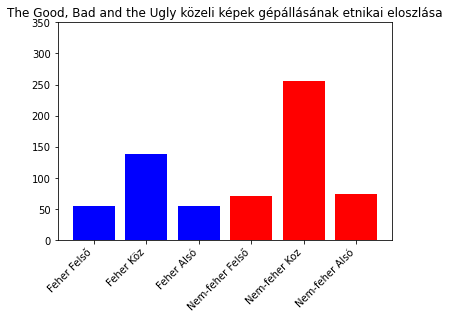

In [ ]:
import matplotlib.pyplot as plt
   
values = [GBU_white_High,GBU_white_Med, GBU_white_Low,GBU_non_white_High,GBU_non_white_Med,GBU_non_white_Low]

plt.bar(['Feher Felső', 'Feher Köz', 'Feher Alsó','Nem-feher Felső','Nem-feher Koz','Nem-feher Alsó' ],values, color = ['blue','blue','blue','red','red','red'])
plt.ylim(0,350)
plt.xticks(rotation=45, ha='right')
plt.title('The Good, Bad and the Ugly közeli képek gépállásának etnikai eloszlása')
plt.show()


